In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
sns.set(font_scale=1.3, style='ticks')


In [2]:
#Specify number of replicates (crosses) and model/results folders

num_crosses = 4
train_dir = '/home/jlinder/borzoi_sc/borzoi/examples/saved_models'

#Padding for drawing text annotations within plots
eps = 0.05


In [3]:
#Read target descriptions

fold3_acc_file = '%s/f3c0/testg_rna3_no_unc-0/acc.txt' % (train_dir)
fold3_acc_df = pd.read_csv(fold3_acc_file, sep='\t', index_col=0).reset_index(drop=True)

#Get experimental assay types
descriptions = fold3_acc_df.description
experiments = pd.Series([desc.split(':')[0] for desc in descriptions])
experiments.value_counts()


RNA3    851
dtype: int64

In [4]:
#Get a mask of 3'-RNA-only targets
rna_mask = (experiments=='RNA3')


In [5]:
#Read test set accuracies

cross_pearsonr = []
cross_npearsonr = []

#Load per-cross performance (replicates)
for ci in range(num_crosses):
    cross_acc_file = '%s/f3c%d/testg_rna3_no_unc-0/acc.txt' % (train_dir, ci)
    cross_acc_df = pd.read_csv(cross_acc_file, sep='\t', index_col=0)
    
    #Store gene-level Pearson correlation
    cross_pearsonr.append(cross_acc_df.pearsonr)
    
    #Store mean-subtracted, quantile-normalized Pearson correlation
    cross_npearsonr.append(cross_acc_df.pearsonr_norm)

#Load ensemble performance (store as last cross)
cross_acc_file = '%s/f3c0/testg_rna3_no_unc-0/acc_ens.txt' % train_dir
cross_acc_df = pd.read_csv(cross_acc_file, sep='\t', index_col=0)
cross_pearsonr.append(cross_acc_df.pearsonr)
cross_npearsonr.append(cross_acc_df.pearsonr_norm)

cross_pearsonr = np.array(cross_pearsonr)
cross_npearsonr = np.array(cross_npearsonr)

#Average across replicates
mean_pearsonr = cross_pearsonr[:-1, :].mean(axis=0)
mean_npearsonr = cross_npearsonr[:-1, :].mean(axis=0)

#Get ensemble performance
ens_pearsonr = cross_pearsonr[-1:, :].mean(axis=0)
ens_npearsonr = cross_npearsonr[-1:, :].mean(axis=0)


In [6]:
#Print per-replicate performance (last entry is ensemble)
cross_pearsonr.mean(axis=1)


array([0.82682009, 0.82752623, 0.8282647 , 0.83186852, 0.83820865])

In [7]:
#Print per-replicate specificity performance (last entry is ensemble)
cross_npearsonr.mean(axis=1)


array([0.5988436 , 0.59188479, 0.59900379, 0.59996096, 0.61979175])

## RNA3

In [8]:
#Check outliers
len(np.nonzero(mean_pearsonr[rna_mask] < 0.75)[0])


40

In [9]:
#Check outliers
len(np.nonzero(mean_pearsonr[rna_mask] > 0.92)[0])


0

(0.75, 0.89)

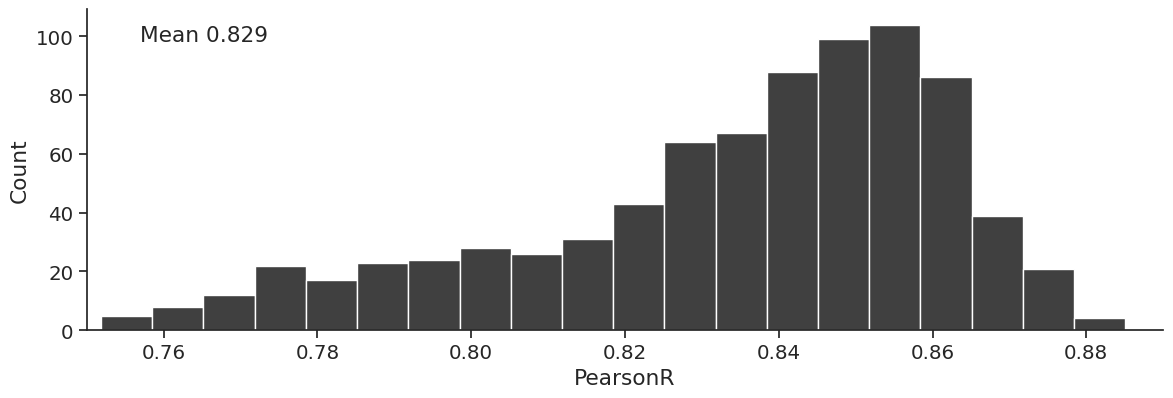

In [11]:
#Plot distribution of gene-level test set pearson correlations (average of 4 replicates)
keep_index = np.nonzero((mean_pearsonr[rna_mask] >= 0.75) & (mean_pearsonr[rna_mask] <= 0.92))[0]

sns.displot(mean_pearsonr[rna_mask][keep_index], bins=20, aspect=3, height=4, color='black')
plt.gca().set_xlabel('PearsonR')
plt.gca().text(eps, 1-eps, 'Mean %.3f' % mean_pearsonr[rna_mask].mean(), 
               verticalalignment='top', transform=plt.gca().transAxes)
plt.xlim(0.75, 0.89)

plt.savefig('genes3_hist_mean.pdf')


In [12]:
#Check outliers
len(np.nonzero(ens_pearsonr[rna_mask] < 0.75)[0])


25

In [13]:
#Check outliers
len(np.nonzero(ens_pearsonr[rna_mask] > 0.92)[0])


0

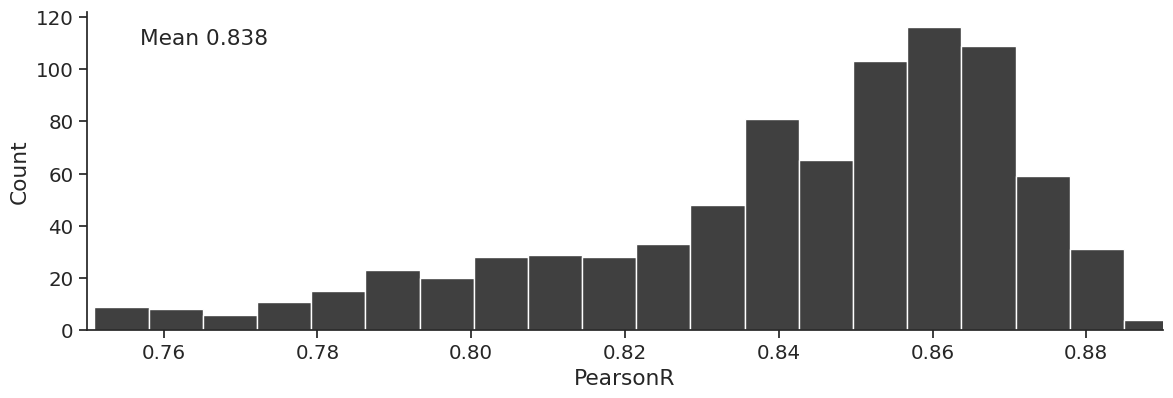

In [15]:
#Plot distribution of gene-level test set pearson correlations (ensemble)
keep_index = np.nonzero((ens_pearsonr[rna_mask] >= 0.75) & (ens_pearsonr[rna_mask] <= 0.92))[0]

sns.displot(ens_pearsonr[rna_mask][keep_index], bins=20, aspect=3, height=4, color='black')
plt.gca().set_xlabel('PearsonR')
plt.gca().text(eps, 1-eps, 'Mean %.3f' % ens_pearsonr[rna_mask].mean(), 
               verticalalignment='top', transform=plt.gca().transAxes)
plt.xlim(0.75, 0.89)

plt.savefig('genes3_hist_ens.pdf')


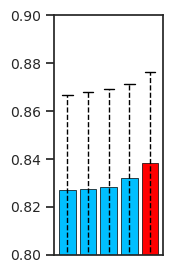

In [16]:
#Plot replicate and ensemble performances, average and 5th / 95th percentiles

q_lo = 0.05
q_hi = 0.95

#Get mean and quantiles
acc_mean = np.mean(cross_pearsonr, axis=1)
acc_lo = np.quantile(cross_pearsonr, q=q_lo, axis=1)
acc_hi = np.quantile(cross_pearsonr, q=q_hi, axis=1)

f = plt.figure(figsize=(2, 3))

plt.bar([0, 1, 2, 3], acc_mean[:-1], color='deepskyblue', edgecolor='black', linewidth=0.5)
plt.bar([4], acc_mean[-1:], color='red', edgecolor='black', linewidth=0.5)

#Loop over metrics (last is ensemble)
for j in range(5) :
    plt.plot([j, j], [acc_lo[j], acc_hi[j]], linewidth=1, color='black', linestyle='--')
    plt.plot([j - 0.25, j + 0.25], [acc_lo[j], acc_lo[j]], linewidth=1, color='black', linestyle='-')
    plt.plot([j - 0.25, j + 0.25], [acc_hi[j], acc_hi[j]], linewidth=1, color='black', linestyle='-')

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylim(0.80, 0.90)

plt.tight_layout()

plt.savefig('acc_gene3_bars.eps')

plt.show()


In [17]:
#Check outliers
len(np.nonzero(mean_npearsonr[rna_mask] < 0.30)[0])


6

In [18]:
#Check outliers
len(np.nonzero(mean_npearsonr[rna_mask] > 0.80)[0])


0

(0.3, 0.75)

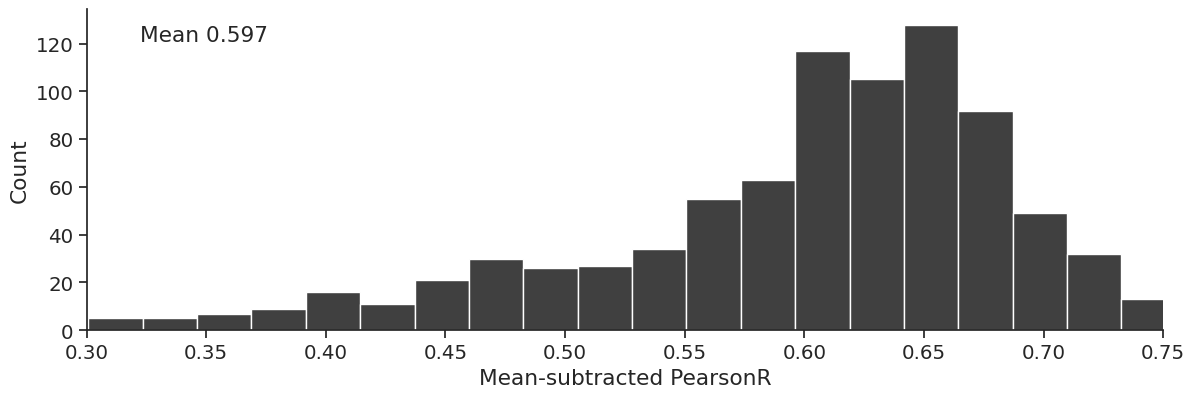

In [19]:
#Plot distribution of mean-subtracted, quantile-normalized gene-level test set pearson correlations (average of 4 replicates)
keep_index = np.nonzero((mean_npearsonr[rna_mask] >= 0.30) & (mean_npearsonr[rna_mask] <= 0.80))[0]

sns.displot(mean_npearsonr[rna_mask][keep_index], bins=20, aspect=3, height=4, color='black')
plt.gca().set_xlabel('Mean-subtracted PearsonR')
plt.gca().text(eps, 1-eps, 'Mean %.3f' % mean_npearsonr[rna_mask].mean(), 
               verticalalignment='top', transform=plt.gca().transAxes)
plt.xlim(0.30, 0.75)

plt.savefig('genes3_nhist_mean.pdf')


In [20]:
#Check outliers
len(np.nonzero(ens_npearsonr[rna_mask] < 0.30)[0])


6

In [21]:
#Check outliers
len(np.nonzero(ens_npearsonr[rna_mask] > 0.80)[0])


0

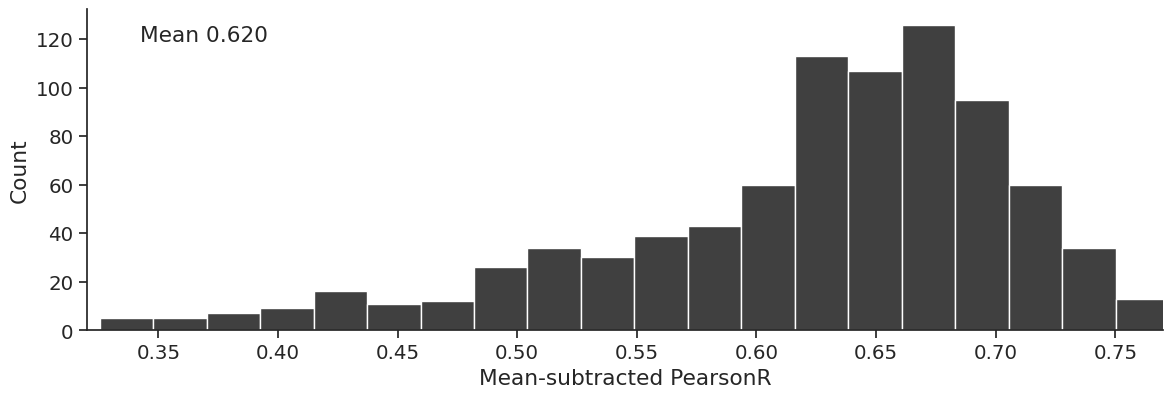

In [24]:
#Plot distribution of mean-subtracted, quantile-normalized gene-level test set pearson correlations (ensemble)
keep_index = np.nonzero((ens_npearsonr[rna_mask] >= 0.30) & (ens_npearsonr[rna_mask] <= 0.80))[0]

sns.displot(ens_npearsonr[rna_mask][keep_index], bins=20, aspect=3, height=4, color='black')
plt.gca().set_xlabel('Mean-subtracted PearsonR')
plt.gca().text(eps, 1-eps, 'Mean %.3f' % ens_npearsonr[rna_mask].mean(), 
               verticalalignment='top', transform=plt.gca().transAxes)
plt.xlim(0.32, 0.77)

plt.savefig('genes3_nhist_ens.pdf')


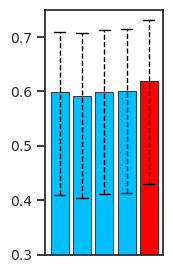

In [25]:
#Plot replicate and ensemble specificity performances, average and 5th / 95th percentiles

q_lo = 0.05
q_hi = 0.95

#Get mean and quantiles
acc_mean = np.mean(cross_npearsonr, axis=1)
acc_lo = np.quantile(cross_npearsonr, q=q_lo, axis=1)
acc_hi = np.quantile(cross_npearsonr, q=q_hi, axis=1)

f = plt.figure(figsize=(2, 3))

plt.bar([0, 1, 2, 3], acc_mean[:-1], color='deepskyblue', edgecolor='black', linewidth=0.5)
plt.bar([4], acc_mean[-1:], color='red', edgecolor='black', linewidth=0.5)

#Loop over metrics (last is ensemble)
for j in range(5) :
    plt.plot([j, j], [acc_lo[j], acc_hi[j]], linewidth=1, color='black', linestyle='--')
    plt.plot([j - 0.25, j + 0.25], [acc_lo[j], acc_lo[j]], linewidth=1, color='black', linestyle='-')
    plt.plot([j - 0.25, j + 0.25], [acc_hi[j], acc_hi[j]], linewidth=1, color='black', linestyle='-')

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylim(0.30, 0.75)

plt.tight_layout()

plt.savefig('acc_ngene3_bars.eps')

plt.show()
